## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [21]:
!pip uninstall -y skforecast

Found existing installation: skforecast 0.1.9
Uninstalling skforecast-0.1.9:
  Successfully uninstalled skforecast-0.1.9


In [26]:
!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@feature/pandas_exog


  Cloning https://github.com/JoaquinAmatRodrigo/skforecast (to revision feature/pandas_exog) to /tmp/pip-req-build-jci7shie
  Created wheel for skforecast: filename=skforecast-0.1.10-py3-none-any.whl size=51373 sha256=c152d4eb8d3fdc71a1b9118e57dc1501e2c3ba76df19f2ec146eab44e8e07228
  Stored in directory: /tmp/pip-ephem-wheel-cache-wbe1856f/wheels/f9/fb/6c/6efd81f818901f474db58355c1537b01ab43df1de952e8ca78
Successfully built skforecast
  Attempting uninstall: skforecast
    Found existing installation: skforecast 0.1.9
    Uninstalling skforecast-0.1.9:
      Successfully uninstalled skforecast-0.1.9


## Data

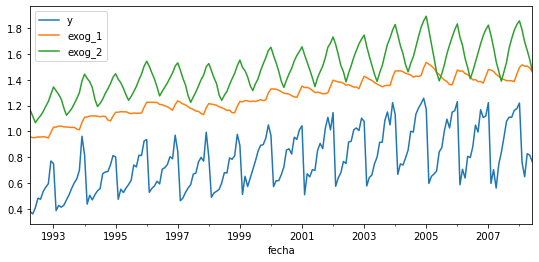

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

In [3]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

## Train forecaster

In [5]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(),
                    lags      = 15
                )

forecaster.fit(
    y    = data_train['y'],
    exog = data_train[['exog_1', 'exog_2']]
)

forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: True, <class 'pandas.core.frame.DataFrame'>
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

## Prediction

If the `Forecaster` has been trained with exogenous variables, they shlud be provided when predictiong.

In [6]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['exog_1', 'exog_2']].values
               )
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

fecha
2005-07-01    0.965051
2005-08-01    1.014752
2005-09-01    1.140090
Freq: MS, dtype: float64

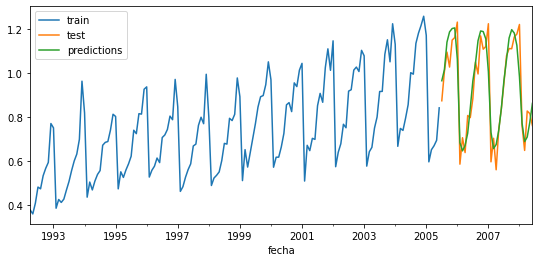

In [7]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [8]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008474661390588436


## Feature importance

In [36]:
# When using as regressor LinearRegression, Ridge or Lasso
forecaster.get_coef()

# When using as regressor RandomForestRegressor or GradientBoostingRegressor
# forecaster.get_feature_importances()

array([ 0.1173852 ,  0.0290203 ,  0.02626445, -0.06322356, -0.04009523,
       -0.00921489, -0.04732691, -0.00662549,  0.01139862,  0.01485692,
        0.15042588,  0.56962708,  0.01581026, -0.08791199, -0.06785373,
        0.09607342,  0.21051962])

## Extract training matrix

In [28]:
X, y = forecaster.create_train_X_y(
            y    = data_train['y'],
            exog = data_train[['exog_1', 'exog_2']].values
        )